In [315]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()

#Machine learning stuff
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier   #This is a single decision tree
from sklearn.ensemble import ExtraTreesClassifier #Random forest of trees
import graphviz                                   #This package lets you visualize the tree
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import train_test_split

In [316]:
#Read in Stata datafile
#data_stata = pd.io.stata.read_stata('../ProjectDef/cnsfinall2.dta')
#Convert to .csv. Now you never need to do this again
#data_stata.to_csv('../Data/cns_data.csv')

In [317]:
data_raw = pd.read_csv("/Users/michael/Documents/Grad school other/ML/Data/cns_data.csv")   #Using Pandas for data manipulation

In [318]:
#Delete useless columns (like surename, initials, etc.)
data_df = data_raw.drop(['surnamenam','patinit','patientreg','mothinit'],axis=1)

Here are the actual diagnoses:

In [319]:
data_df.diag.unique()

array(['malaria', '0.0', 'cereb malaria', 'virus-bacteria', 'bacteremia',
       'bact meningitis', 'virus-other', 'virus-malaria',
       'malaria-bacterial', 'tb', 'virus', 'crypto'], dtype=object)

In [320]:
#Adding a variable that is just 'month and day' - seems better to capture seasonality.
data_df['month'] = pd.DatetimeIndex(data_df['incdate']).month
data_df['day'] = pd.DatetimeIndex(data_df['incdate']).day
data_df['monthday'] = data_df['month']*30+data_df['day']

In [321]:
#sum(clin_df['incirrit'] == "Don't know")

In [322]:
#Select input features
#6-8 adding inclusion criteria and rdttest MLW
clin_df = data_df.loc[:,['glasgtot','blanttot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinearinf','clinanemia','clintonsil','clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','head','muscle','conv',\
                         'sex','ageyrs','agemth','incdate',\
                         'temp','card','resp','sbp','dbp','weight','height','muac',\
                          'mhhosp', 'mhdevsp', 'mhsickle', 'mhchronstat',\
                         'monthday','dimain', \
                         'incirrit', 'inchead', 'incphoto',\
                         'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                          'incpurp','diag']] #This is the final diagnosis - will be the 'label'

In [323]:
#Convert the date into a useful value. This just counts the days from the beginning of the dataset 
clin_df['incdate'] = pd.to_datetime(clin_df['incdate'])
clin_df['date'] = (clin_df['incdate'] - clin_df['incdate'].min())  / np.timedelta64(1,'D')

#Mapping yes/no to 1/0
clin_df['clinjaund'] = clin_df.clinjaund.map({'Yes': 1, 'No': 0})
clin_df['clinhepato'] = clin_df.clinhepato.map({'Yes': 1, 'No': 0})
clin_df['clinspleno'] = clin_df.clinspleno.map({'Yes': 1, 'No': 0})
clin_df['clinconv'] = clin_df.clinconv.map({'Yes': 1, 'No': 0})
clin_df['clindehyd'] = clin_df.clindehyd.map({'Yes': 1, 'No': 0})
clin_df['clinoedem'] = clin_df.clinoedem.map({'Yes': 1, 'No': 0})
clin_df['clinlymph'] = clin_df.clinlymph.map({'Yes': 1, 'No': 0})
clin_df['clinresp'] = clin_df.clinresp.map({'Yes': 1, 'No': 0})
clin_df['clinablung'] = clin_df.clinablung.map({'Yes': 1, 'No': 0})
clin_df['clincyan'] = clin_df.clincyan.map({'Yes': 1, 'No': 0})
clin_df['clincapref'] = clin_df.clincapref.map({'Yes': 1, 'No': 0})
clin_df['clincoldext'] = clin_df.clincoldext.map({'Yes': 1, 'No': 0})
clin_df['clinearinf'] = clin_df.clinearinf.map({'Yes': 1, 'No': 0})
clin_df['clintonsil'] = clin_df.clintonsil.map({'Yes': 1, 'No': 0})
clin_df['clinorcand'] = clin_df.clinorcand.map({'Yes': 1, 'No': 0})
clin_df['clinhemmor'] = clin_df.clinhemmor.map({'Yes': 1, 'No': 0})
clin_df['clinaids'] = clin_df.clinaids.map({'Yes': 1, 'No': 0})
clin_df['vom'] = clin_df.vom.map({'Yes': 1, 'No': 0})
clin_df['diar'] = clin_df.diar.map({'Yes': 1, 'No': 0})
clin_df['headache'] = clin_df['head'] #Since 'head' is a function
clin_df['conv'] = clin_df.conv.map({'Yes': 1, 'No': 0})
clin_df['ageym'] = clin_df.ageyrs.astype(float)*12.
clin_df.agemth = clin_df.agemth.astype(float)
clin_df['age'] = clin_df.ageym + clin_df.agemth


#Medical history variables
clin_df['mhhosp'] = clin_df.mhhosp.map({'Yes': 1, 'No':0})


#some slightly more compliated mappings
clin_df['abdpain'] = clin_df.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
clin_df['headache'] = clin_df.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['muscle'] = clin_df.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})

clin_df['dimain'] = clin_df.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                       "Other":3})

clin_df['mhdevsp'] = clin_df.mhdevsp.map({'OTHER':1, 'GLOBAL DEVELOPMENTAL DELAY':1, 'HYDROCEPHALUS':1,
       'HEARING LOSSES':1, 'MOTOR DEVELOPEMENTAL DELAY':1,
       'SPEECH DEVELOPEMENTAL DELAY':1})

#Mapping of inclusion variables 6-8 MLW
clin_df['incirrit'] = clin_df.incirrit.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['inchead'] = clin_df.inchead.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incphoto'] = clin_df.incphoto.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incfont'] = clin_df.incfont.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incneuro'] = clin_df.incneuro.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incseiza'] = clin_df.incseiza.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incseizh'] = clin_df.incseizh.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incpurp'] = clin_df.incpurp.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})


#This coding is going to be important. You'll want to figure out which categories are useful, and which
#are practical.
clin_df['diag'] = clin_df.diag.map({'malaria':0, 'cereb malaria':0,'virus-malaria':0,\
                                    'virus-bacteria':1, 'bacteremia':1,'bact meningitis':1,\
                                    'virus-other':2,'virus':2,'malaria-bacterial':3,\
                                    'tb':4,'crypto':4, '0.0':5})

In [324]:
#A lot of these have very few actual answers. i.e., 'headache.' What happens if you map 'nan' to 'No'?
#This is probably something we'll want to play around with.
values = {'clinjaund':0,'clinhepato':0,'clinaids':0,'clinhemmor':0,'clinorcand':0,'clintonsil':0,'clinearinf':0,\
          'clinresp':0,'clinlymph':0,'clindehyd':0,'clinoedem':0,'clinablung':0,'clincyan':0,'clincapref':0,
          'clincoldext':0, 'mhchronstat':0, 'mhdevsp':0,\
         'conv':0,'abdpain':0,'vom':0,'diar':0,'headache':0,'muscle':0}
clin_df = clin_df.fillna(value=values)

In [325]:
#You really shouldn't use the initial diagnosis as a continuous variable ,
#you need to map it into a set of yes/no question.
clin_df['CMalaria'] = clin_df.dimain.map({0:1,1:0,2:0,3:0})
clin_df['Enceph'] = clin_df.dimain.map({0:0,1:1,2:0,3:0})
clin_df['Mening'] = clin_df.dimain.map({0:0,1:0,2:1,3:0})
clin_df['Other'] = clin_df.dimain.map({0:0,1:0,2:0,3:1})

print(clin_df.dimain.unique())

[0. 1. 2. 3.]


In [326]:
#Pick the features to classify with.
Xlabels = ['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                      'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                      'incpurp'] #This is just for plotting.
X_pd = clin_df.loc[:,['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clintonsil','clinhepato','clinaids','clinhemmor','clinorcand','clinearinf',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                       'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                      'incpurp','diag']]
X_pd = X_pd.dropna()  #Drop cases that have nan for *any* entry

In [327]:
#Get things into the correct format for scikit-learn. I've tried to use the convention throughout that variables
#ending in 'pd' are pandas dataframes.
Input = X_pd.as_matrix()        #creates a numpy array
Features = Input[:,0:-1].copy() #separate the features and labels
Labels = Input[:,-1].copy()
ncase = len(Input[:,0])
print(ncase)                     #checking that there are a reasonable number of cases left

361


In [328]:
X = Features.copy()  #changing to X and y. For no real reason
y = Labels.copy()

In [329]:
#skl will split the data into training and test for you. Right now, I'm training on 2/3 of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(np.shape(X))

(361, 47)


In [330]:
#Actual classifier. This is doing n_estimators trees, up to max_depth cuts. Something to play with.
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0,max_depth=50 )

#Fit the classifier.
forest.fit(X_train, y_train)

#extract the 'importances' of the features
importances = forest.feature_importances_
#calculate standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature 0 (0.101819)
2. feature 2 (0.054643)
3. feature 1 (0.045922)
4. feature 22 (0.044878)
5. feature 24 (0.040474)
6. feature 25 (0.039368)
7. feature 29 (0.038060)
8. feature 26 (0.037654)
9. feature 7 (0.036647)
10. feature 27 (0.036520)


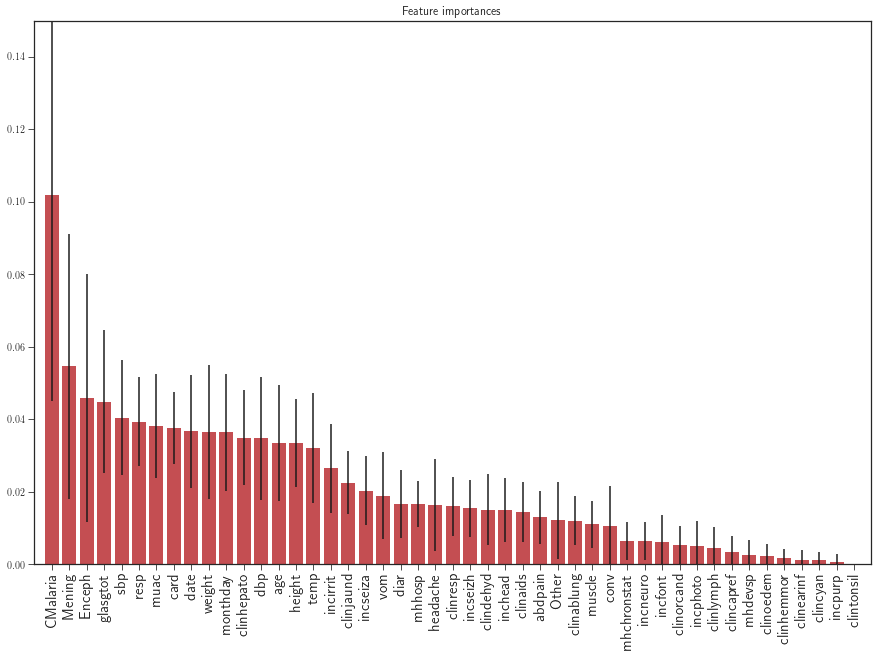

In [331]:
# Print the feature ranking
Xlabels = np.array(Xlabels)
PlotLabels = Xlabels[indices]
print("Feature ranking:")
#for full feature listing use this as the range: X.shape[1]
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), PlotLabels, rotation='vertical',fontsize=15)
plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.15)
plt.show()

In [313]:
#Make the predictions on the test data
y_pred_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

In [314]:
#Print the confusion matrix:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[37  0  0 11]
 [ 2  1  0 11]
 [ 2  0  0  0]
 [ 9  2  0 45]]
             precision    recall  f1-score   support

        0.0       0.74      0.77      0.76        48
        1.0       0.33      0.07      0.12        14
        2.0       0.00      0.00      0.00         2
        3.0       0.67      0.80      0.73        56

avg / total       0.65      0.69      0.66       120



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [259]:
#Because this is a random forest, the output is actually a probability of being in each class. So this is looking
#at the maximum probability for each test case - it gives us a sense of how confident the classifier is in each
#
probmax = np.amax(y_pred_prob,axis=1)
edges = np.linspace(0,1,101)

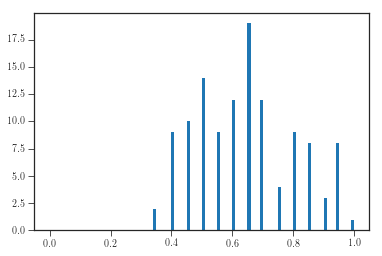

In [260]:
a,b,c = plt.hist(probmax,bins=edges)

In [263]:
'''
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data)
graph.render("iris")
'''

'\ndot_data = tree.export_graphviz(clf, out_file=None) \ngraph = graphviz.Source(dot_data)\ngraph.render("iris")\n'

In [294]:
X_pd['incseiza']

0      0
2      0
9      1
12     0
13     0
18     0
19     1
20     0
28     1
30     0
34     1
39     0
53     0
60     0
63     0
66     1
70     1
80     0
81     0
82     1
83     0
84     0
85     0
86     1
87     1
89     1
90     1
91     1
93     0
95     1
      ..
442    1
443    0
444    1
445    0
446    0
447    0
448    1
450    1
452    1
453    1
454    0
455    0
459    1
460    0
461    1
463    0
464    0
465    1
466    1
467    0
469    0
470    0
471    0
472    1
473    0
474    0
475    0
476    1
477    0
478    0
Name: incseiza, Length: 361, dtype: int64

In [295]:
data_df['incseiza']

0       No
1      Yes
2       No
3       No
4       No
5      Yes
6       No
7       No
8      Yes
9      Yes
10      No
11      No
12      No
13      No
14     Yes
15      No
16      No
17     Yes
18      No
19     Yes
20      No
21     Yes
22      No
23      No
24      No
25      No
26      No
27      No
28     Yes
29     Yes
      ... 
450    Yes
451    Yes
452    Yes
453    Yes
454     No
455     No
456    Yes
457    Yes
458    Yes
459    Yes
460     No
461    Yes
462    Yes
463     No
464     No
465    Yes
466    Yes
467     No
468     No
469     No
470     No
471     No
472    Yes
473     No
474     No
475     No
476    Yes
477     No
478     No
479     No
Name: incseiza, Length: 480, dtype: object